In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, norm, nbinom
from scipy.special import gamma, gammaln

In [2]:
alpha= 50
gamma(2*alpha+1)/gamma(alpha)

1.5342593781274831e+95

In [3]:
np.exp(gammaln(2*alpha+1)-gammaln(alpha))

1.5342593781274813e+95

In [30]:
np.random.randint?

In [33]:
def generate_normal_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        mean = np.random.randn()*5
        var = np.random.randn()*1
        if var < 0:
            var = var * -1
        tdata = np.random.normal(mean, var, p)
        data = np.concatenate((data, tdata))
    return data, partition

def generate_poisson_time_series(num, minl=50, maxl=1000):
    data = np.array([], dtype=np.float64)
    partition = np.random.randint(minl, maxl, num)
    for p in partition:
        lamb = np.random.randint(low=1,high=10)
        print(lamb)
        tdata = np.random.poisson(lamb, p)
        data = np.concatenate((data, tdata))
    return data, partition


In [34]:
#Read and plot data

DIR_FILENAME = 'dowj_1996-2018.csv'
#dataset = np.genfromtxt(DIR_FILENAME, delimiter=',')


dataset_n, part_n = generate_normal_time_series(8, 50, 200)
dataset_p, part_p = generate_poisson_time_series(8, 50, 200)

2
4
2
6
2
3
2
9


In [36]:
#Define functions

def const_hazard(r,lambda_):
    probs = np.ones(r)/lambda_
    return probs

def pred_prob(x,mu,alpha,kappa,beta,mean,var,dist,typ):
    if dist=='norm':
        if typ=='both_unknown':
            prec = (alpha*kappa)/(beta*(kappa+1))
            df = 2*alpha
            gamma_part = np.exp(gammaln(2*alpha+1)-gammaln(alpha))
            pred = gamma((df+1)/2)/(gamma(df/2)*np.sqrt(np.pi*df*(1/prec))*((1+((x-mu)**2)/(df*(1/prec)))**((df+1)/2)))
        if typ == 'var_known':
            pred = norm.pdf(x, loc=mu,scale=kappa+var)
        if typ == 'mean_known':
            deg_freedom = 2*alpha
            precision = alpha/beta
            pred = t.pdf(x, df=deg_freedom,loc=mean,scale=np.sqrt(precision))
            
        
    if dist=='poisson':  
        gamma_part = gamma(x+alpha)/(gamma(alpha)*gamma(x+1))
        pred = gamma_part* ((beta/(beta+1))**alpha)*((1/(beta+1))**x)
        
    return pred

def update_stats(x,mu,alpha,kappa,beta,mean,var,dist,typ):
    if dist =='norm':
        if typ== 'both_unknown':
            mu, alpha, kappa, beta = (kappa*mu + x) / (kappa+1.), alpha+0.5, kappa+1., beta +((kappa*((x-mu)**2))/(2*(kappa+1.)))
        if typ == 'var_known':
            mu, kappa = mu, kappa
        if typ == 'mean_known':
            alpha,beta = alpha +0.5, beta+ 0.5*((x-mean)**2)
    if dist == 'poisson':
        alpha, beta = alpha + x , beta+1
    return mu, alpha, kappa, beta


In [40]:
def inference(data, mu0 = 0, kappa0 = 1, alpha0= 0.1, beta0= 0.1, lam = [200], dist='norm',typ='mean_known',mean=0,var=1):
    #Initialize
    prob_r = np.zeros((len(data) + 1, len(data) + 1))
    prob_r[0, 0] = 1
    mu, kappa, alpha, beta = np.array([mu0]), np.array([kappa0]), np.array([alpha0]), np.array([beta0])
    
    #Start iteration   
    for t,x in enumerate(data):      
        #Calculate predictive probability for new data point
        pred = pred_prob(x,mu,alpha,kappa,beta,mean,var,dist,typ)
        
        #Calculate growth probability 
        prob_r[1:t+2,t+1] = prob_r[:t+1,t]* pred * (1-const_hazard(t+1,lam))

        #Calculate changepoint probability
        prob_r[0,t+1] = np.sum( prob_r[:t+1,t] * pred * const_hazard(t+1,lam))
        
        #Calculate evidence
        sum_prob_r =  np.sum(prob_r[:,t+1])
        
        #Run length distribution
        prob_r[:,t+1] /= sum_prob_r
        
        #Update sufficient statistics
        mu_n, alpha_n, kappa_n, beta_n = update_stats(x, mu, alpha, kappa,beta,mean,var, dist,typ) 
        mu, kappa, alpha, beta = np.append(np.array([mu0]), mu_n), np.append(np.array([kappa0]), kappa_n), np.append(np.array([alpha0]), alpha_n), np.append(np.array([beta0]), beta_n) 
        print(mu,alpha,kappa,beta)
        
    return prob_r

In [41]:
p = inference(dataset_p,dist='poisson')

/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: overflow encountered in multiply


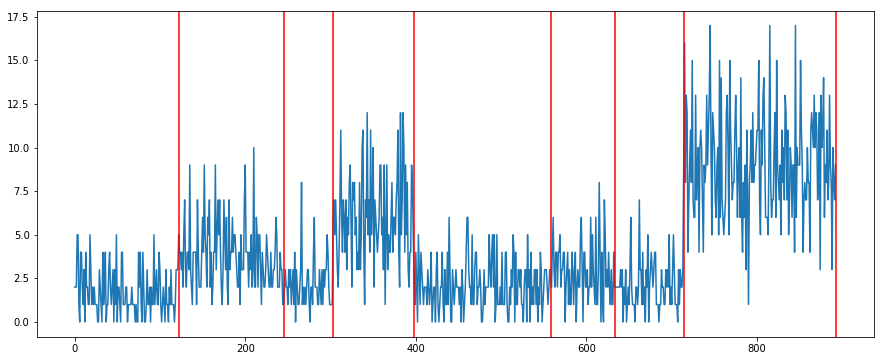

In [38]:
# plot
fig = plt.figure(figsize=(15,6))
plt.plot(dataset_p)
for cp in np.cumsum(part_p):
    plt.axvline(x=cp, color='r')

plt.show()

/home/esraz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


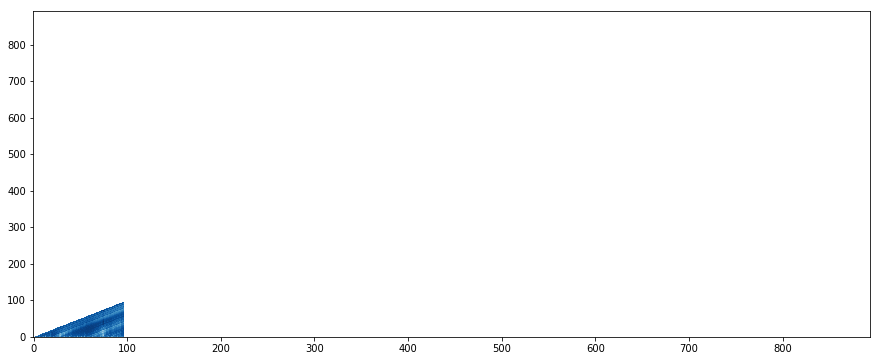

In [39]:
plt.figure(figsize=[15,6])
plt.imshow(-np.log(p), interpolation='none', aspect='auto',
origin='lower', cmap=plt.cm.Blues)
plt.show()